<a href="https://colab.research.google.com/github/shubhpanchal/BikeSharing/blob/main/Bike_Sharing_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime as dt

# Importing Data Viz Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mounting the drive to load the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Loading the dataset
data = pd.read_csv('/content/drive/MyDrive/Almabetter/Alma Capstone Projects Folder/Supervised ML Regression/Bike Sharing Demand Prediction/SeoulBikeData.csv',
                   encoding='ISO-8859-1')

# creating the copy of original data so thatwe do not loose original data accidentally
bike_df = data.copy()

# First look at the data
bike_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Understanding the Data.


In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [5]:
# Lets check the missing values
pd.concat([bike_df.isnull().sum(),round(100*(bike_df.isnull().sum()/len(bike_df)),2)],axis = 1,keys=['Missing Values','% Missing Values'])

,Missing Values,% Missing Values
Date,0,0.0
Rented Bike Count,0,0.0
Hour,0,0.0
Temperature(°C),0,0.0
Humidity(%),0,0.0
Wind speed (m/s),0,0.0
Visibility (10m),0,0.0
Dew point temperature(°C),0,0.0
Solar Radiation (MJ/m2),0,0.0
Rainfall(mm),0,0.0


There are no missing values in the dataset

## Feature Engineering

In [6]:
# Creating Columns that are related to time data
bike_df['Date'] = pd.to_datetime(bike_df['Date'])
bike_df['Year'] = bike_df['Date'].dt.year
bike_df['Month'] = bike_df['Date'].dt.month
bike_df['Day'] = bike_df['Date'].dt.day
bike_df['Day_name'] = bike_df['Date'].dt.day_name()

# Looking at the data
bike_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Day,Day_name
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday


In [7]:
# Renaming the columns
bike_df.rename(columns={'Temperature(°C)': 'Temperature', 'Humidity(%)': 'Humidity','Wind speed (m/s)':'Wind Speed',
                        'Visibility (10m)':'Visibility','Dew point temperature(°C)':'Dew Point Temp','Solar Radiation (MJ/m2)':'Solar Radiation',
                        'Rainfall(mm)':'Rainfall','Snowfall (cm)':'Snowfall'}, inplace=True)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               8760 non-null   datetime64[ns]
 1   Rented Bike Count  8760 non-null   int64         
 2   Hour               8760 non-null   int64         
 3   Temperature        8760 non-null   float64       
 4   Humidity           8760 non-null   int64         
 5   Wind Speed         8760 non-null   float64       
 6   Visibility         8760 non-null   int64         
 7   Dew Point Temp     8760 non-null   float64       
 8   Solar Radiation    8760 non-null   float64       
 9   Rainfall           8760 non-null   float64       
 10  Snowfall           8760 non-null   float64       
 11  Seasons            8760 non-null   object        
 12  Holiday            8760 non-null   object        
 13  Functioning Day    8760 non-null   object        
 14  Year    

## Defining Helper Functions

In [8]:
# Creating a categorical column that represents weekends(saturdays and Sundays)
def weekend(Day_name):
  if (Day_name == 'Saturday'or Day_name =='Sunday'):
    return 1
  else:
    return 0
bike_df['is_weekend'] = bike_df['Day_name'].apply(weekend)

bike_df.head()

# Transforming numerical columns into binary columns for Snowfall, Rainfall and Solar Radiation
def binary_transformation(col):
  if (col > 0):
    return 1
  else:
    return 0

bike_df['Snowfall'] = bike_df['Snowfall'].apply(binary_transformation)
bike_df['Rainfall'] = bike_df['Rainfall'].apply(binary_transformation)
bike_df['Solar Radiation'] = bike_df['Solar Radiation'].apply(binary_transformation)

# Transforming the Visibility Column into Binary Column
def visibility(col):
  if(col<1436.825799):
    return 0
  else:
    return 1

bike_df['Visibility'] = bike_df['Visibility'].apply(visibility)

# Creating new column based on Hour to know the day_time
def day_time(hour):
  if(hour == 6) or(hour == 7) or(hour == 8) or(hour == 9) or(hour == 10) or(hour == 11):
    return 'Morning'
  elif(hour == 12) or(hour == 13) or(hour == 14) or(hour == 15) or(hour == 16):
    return 'Afternoon'
  elif(hour == 17) or(hour == 18) or(hour == 19) or(hour == 20) or(hour == 21) or(hour == 22) or(hour == 23):
    return 'Evening'
  else:
    return 'Night'

bike_df['Day_time'] = bike_df['Hour'].apply(day_time)
bike_df.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind Speed,Visibility,Dew Point Temp,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Year,Month,Day,Day_name,is_weekend,Day_time
0,2017-01-12,254,0,-5.2,37,2.2,1,-17.6,0,0,0,Winter,No Holiday,Yes,2017,1,12,Thursday,0,Night
1,2017-01-12,204,1,-5.5,38,0.8,1,-17.6,0,0,0,Winter,No Holiday,Yes,2017,1,12,Thursday,0,Night
2,2017-01-12,173,2,-6.0,39,1.0,1,-17.7,0,0,0,Winter,No Holiday,Yes,2017,1,12,Thursday,0,Night
3,2017-01-12,107,3,-6.2,40,0.9,1,-17.6,0,0,0,Winter,No Holiday,Yes,2017,1,12,Thursday,0,Night
4,2017-01-12,78,4,-6.0,36,2.3,1,-18.6,0,0,0,Winter,No Holiday,Yes,2017,1,12,Thursday,0,Night


### Changing the Column types

In [9]:
change_to_object =  ['Year','Month','is_weekend','Visibility','Solar Radiation','Rainfall','Snowfall']
for col in change_to_object:
  bike_df[col]=bike_df[col].astype('str')
  print('Successfully Changed the ' + col + ' dtype to :', bike_df[col].dtype)

Successfully Changed the Year dtype to : object
Successfully Changed the Month dtype to : object
Successfully Changed the is_weekend dtype to : object
Successfully Changed the Visibility dtype to : object
Successfully Changed the Solar Radiation dtype to : object
Successfully Changed the Rainfall dtype to : object
Successfully Changed the Snowfall dtype to : object


## Data Description


### Data Description for Numerical Columns

In [10]:
bike_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.5,1065.25,3556.0
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.5,17.25,23.0
Temperature,8760.0,12.882922,11.944825,-17.8,3.50,13.7,22.50,39.4
Humidity,8760.0,58.226256,20.362413,0.0,42.00,57.0,74.00,98.0
Wind Speed,8760.0,1.724909,1.036300,0.0,0.90,1.5,2.30,7.4
Dew Point Temp,8760.0,4.073813,13.060369,-30.6,-4.70,5.1,14.80,27.2
Day,8760.0,15.720548,8.796749,1.0,8.00,16.0,23.00,31.0


### Data Description For Categorical Data

In [11]:
bike_df.describe(include=['object','category']).T

,count,unique,top,freq
Visibility,8760,2,1,5166
Solar Radiation,8760,2,1,4460
Rainfall,8760,2,0,8232
Snowfall,8760,2,0,8317
Seasons,8760,4,Spring,2208
Holiday,8760,2,No Holiday,8328
Functioning Day,8760,2,Yes,8465
Year,8760,2,2018,8016
Month,8760,12,1,744
Day_name,8760,7,Sunday,1296


## Dividing the Data according to their attributes

In [12]:
numeric_features = ['Temperature','Humidity','Wind Speed','Dew Point Temp']
categorical_features = ['Seasons','Holiday','Functioning Day','Year','Month','Day_name','is_weekend','Visibility','Solar Radiation','Rainfall','Snowfall','Day','Hour','Day_time']
label = bike_df['Rented Bike Count']

# Exploratory Data Analysis

### Understanding the Target Variable

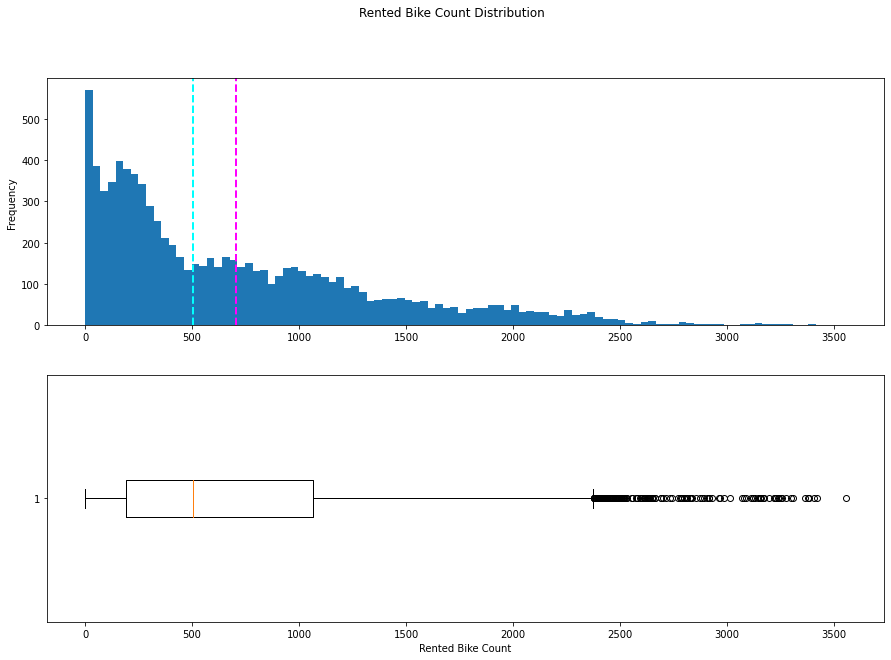

In [13]:
fig,ax = plt.subplots(2,1,figsize=(15,10))
# Plotting the histogram
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Adding vertical Lines for Mean and Median
ax[0].axvline(label.mean(),color='magenta',linestyle='dashed',linewidth=2)
ax[0].axvline(label.median(),color='cyan',linestyle='dashed',linewidth=2)

# Plotting the boxplot
ax[1].boxplot(label,vert=False)
ax[1].set_xlabel('Rented Bike Count')

# Add a title to the figure
fig.suptitle('Rented Bike Count Distribution')

# Show the figure
fig.show()



The plots show that the number of daily rentals ranges from 0 to just over 3,400. However, the mean (and median) number of daily rentals is closer to the low end of that range, with most of the data between 0 and around 2,200 rentals. The few values above this are shown in the box plot as small circles, indicating that they are outliers 

## Univariate Analysis

### Data Distribution for Numeric Columns

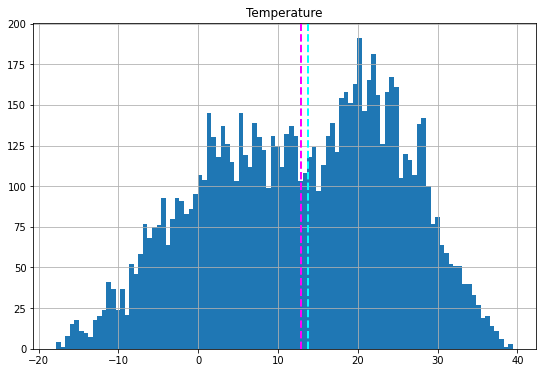

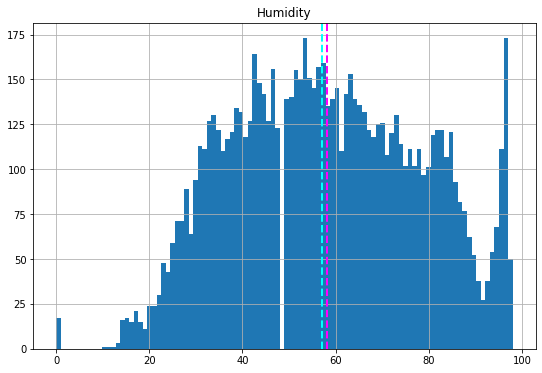

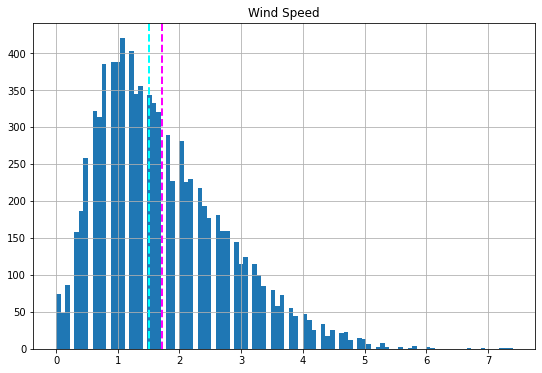

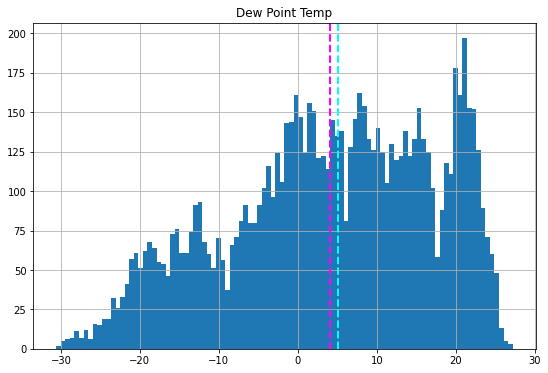

In [14]:
# Plot the histogram for each numeric feature
for col in numeric_features:
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  feature = bike_df[col]
  feature.hist(bins=100,ax=ax)
  ax.axvline(feature.mean(), color='magenta',linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
  ax.set_title(col)
plt.show()

### Data Distribution for Categorical Variable

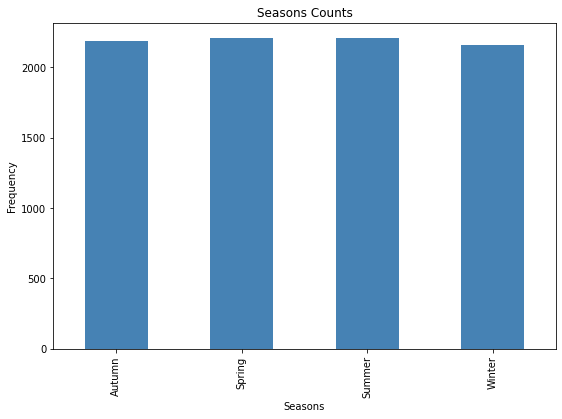

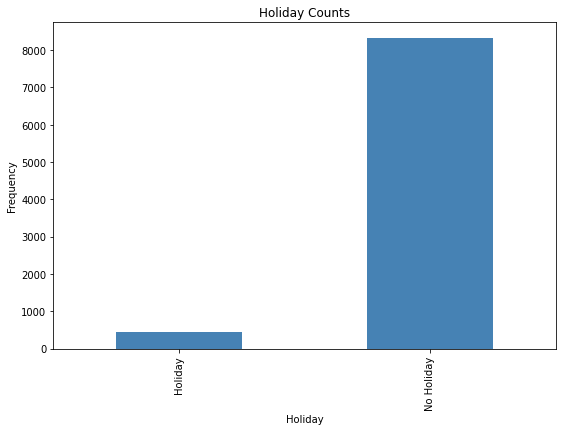

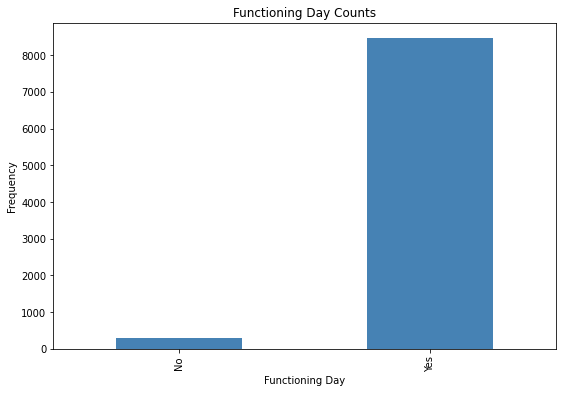

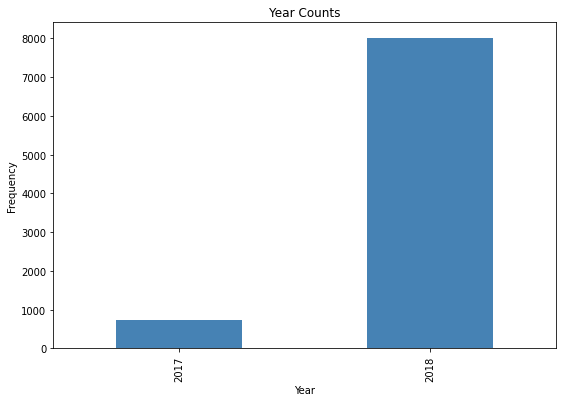

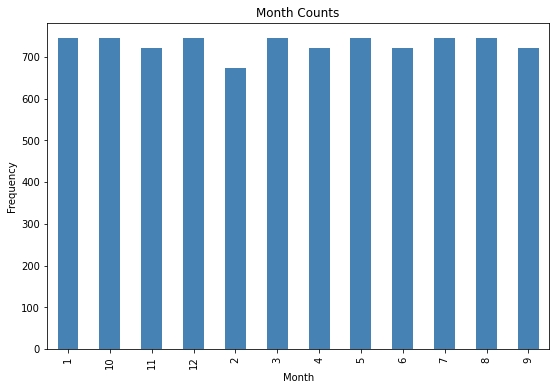

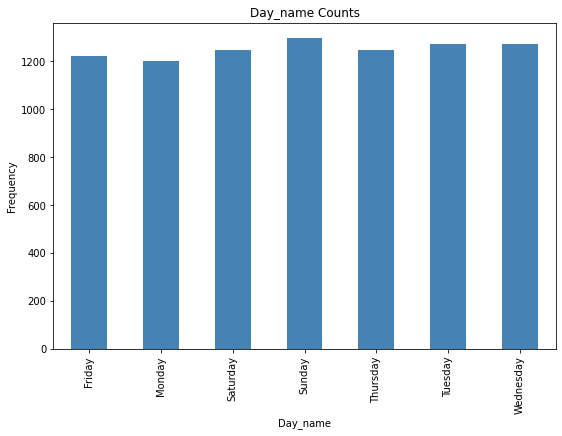

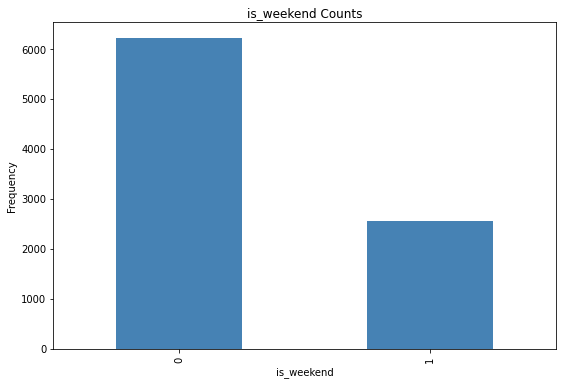

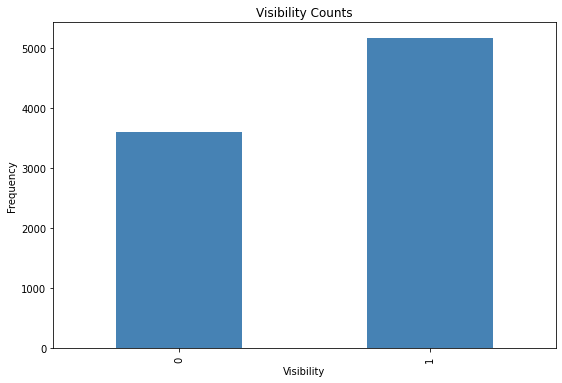

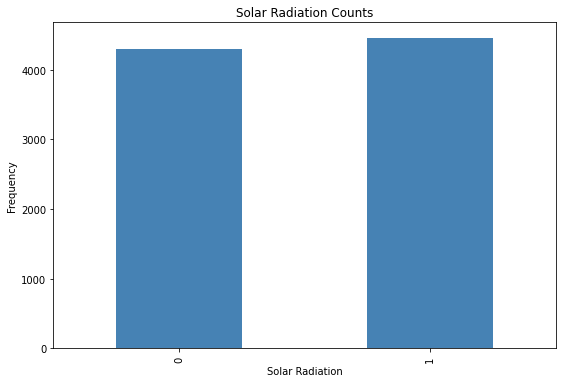

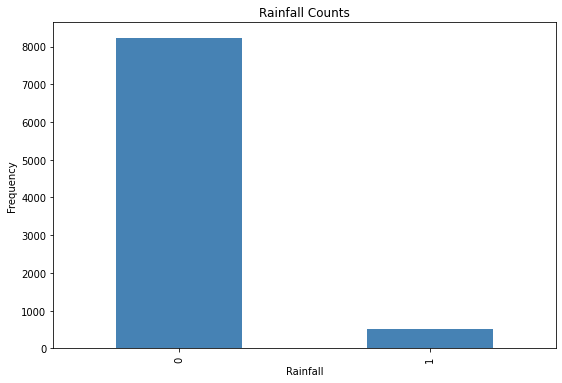

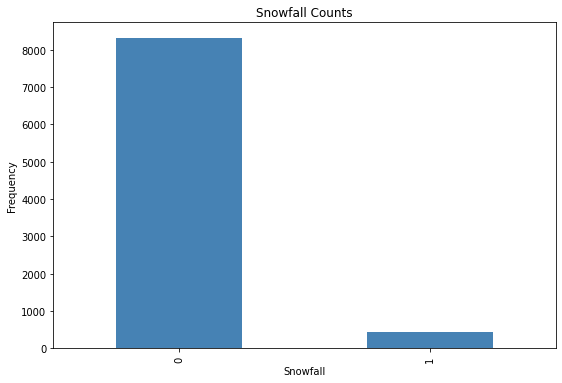

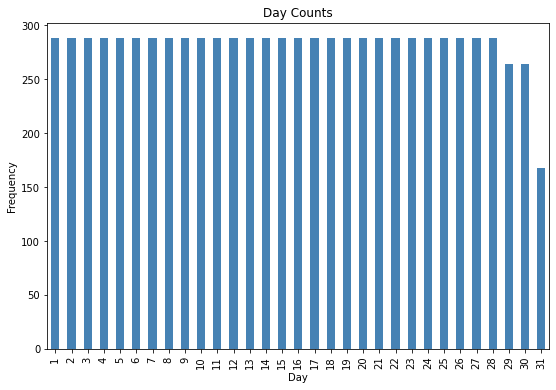

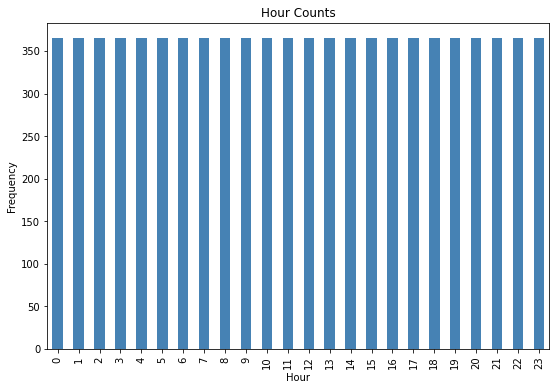

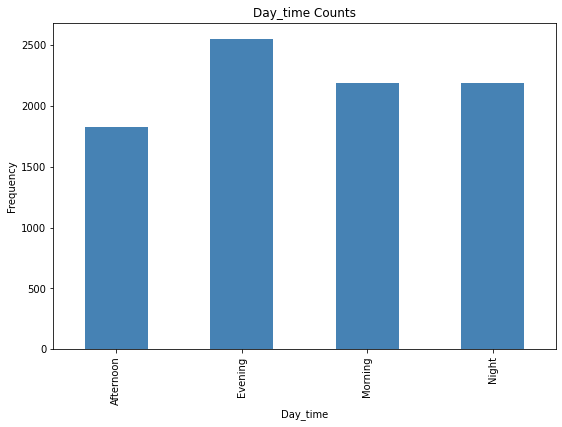

In [15]:
# Plotting the count plot for Categorical Variables
for col in categorical_features:
  counts = bike_df[col].value_counts().sort_index()
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  counts.plot.bar(ax=ax,color='steelblue')
  ax.set_title(col + ' Counts')
  ax.set_xlabel(col)
  ax.set_ylabel('Frequency')
plt.show()

## Bivariate Analysis

### Understanding Relationship of Numeric Columns with Target Variable

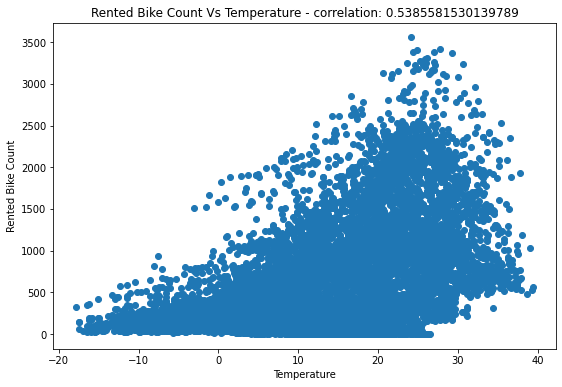

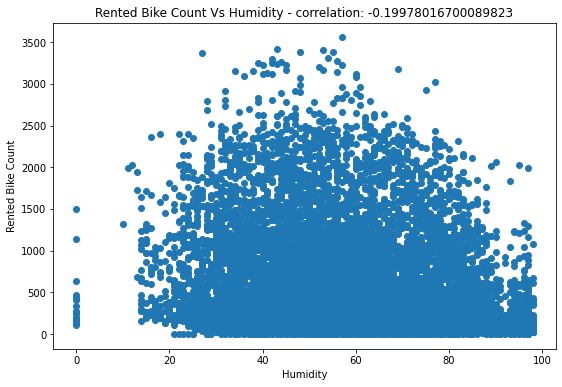

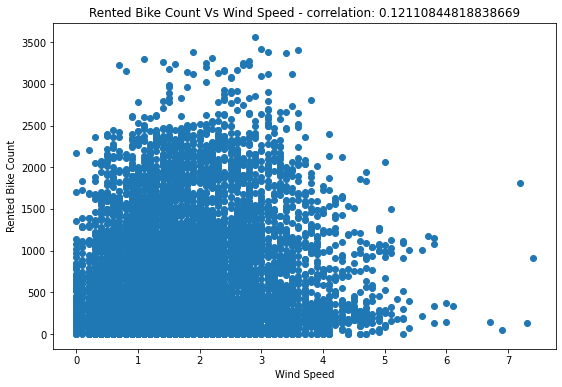

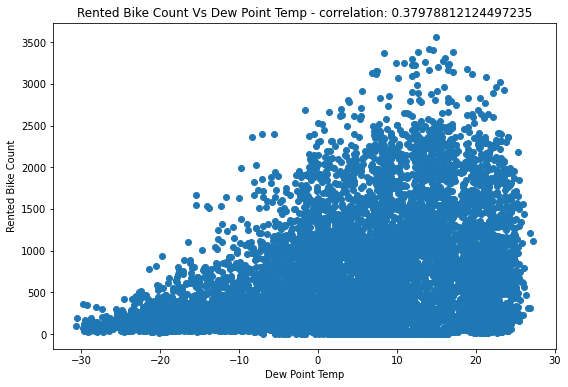

In [16]:
# Plotting regplot for numeric variables
for col in numeric_features:
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  feature = bike_df[col]
  label = bike_df['Rented Bike Count']
  correlation = feature.corr(label)
  plt.scatter(x=feature, y=label)
  plt.xlabel(col)
  plt.ylabel('Rented Bike Count')
  ax.set_title('Rented Bike Count Vs ' + col + ' - correlation: ' + str(correlation))
plt.show()


### Understanding Relationship between Categorical Variable and Target Variable

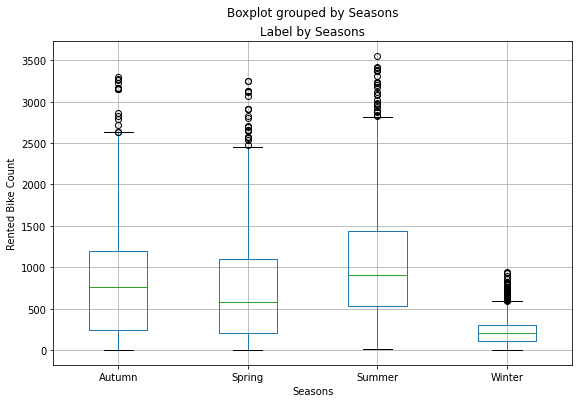

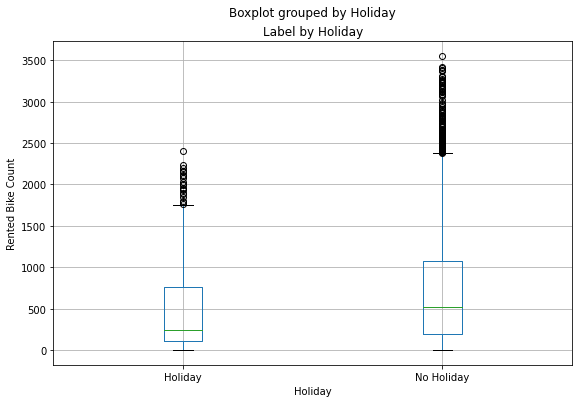

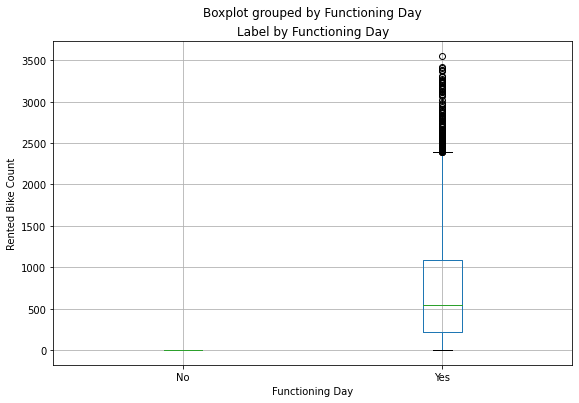

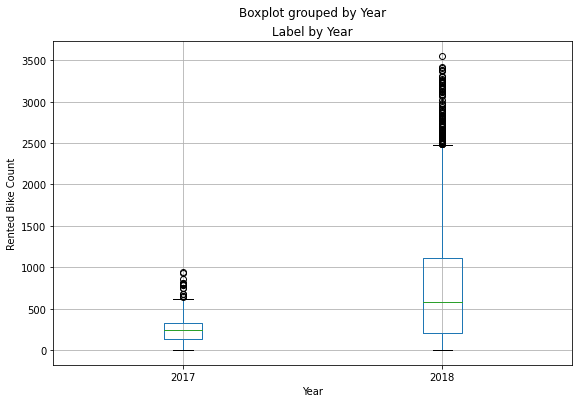

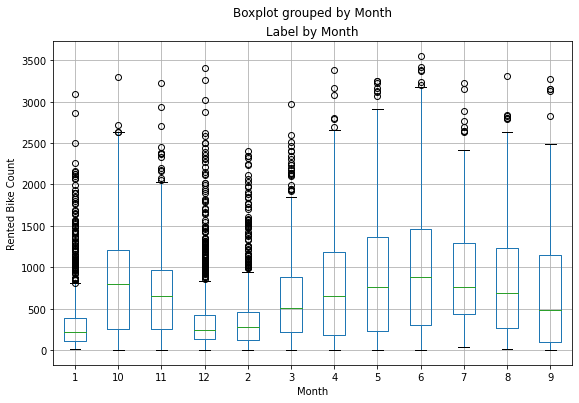

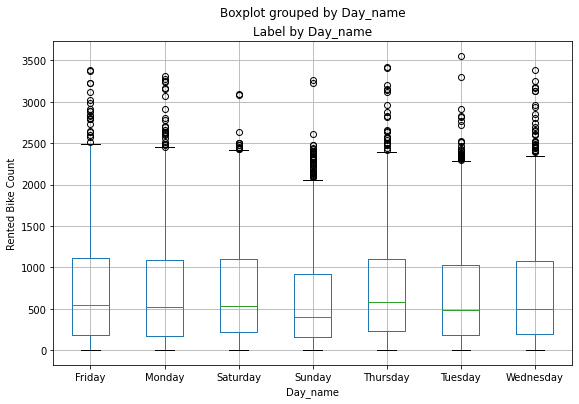

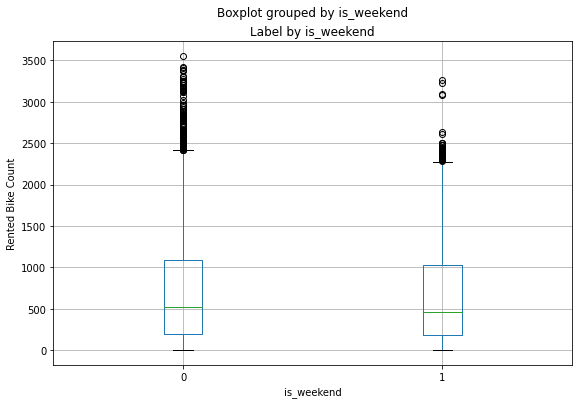

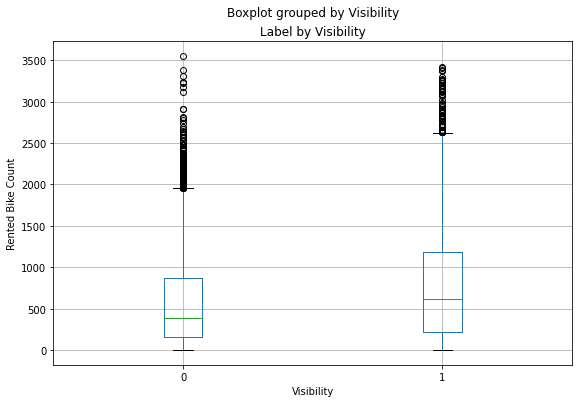

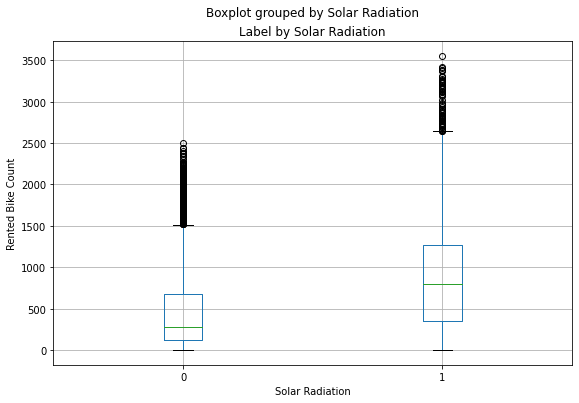

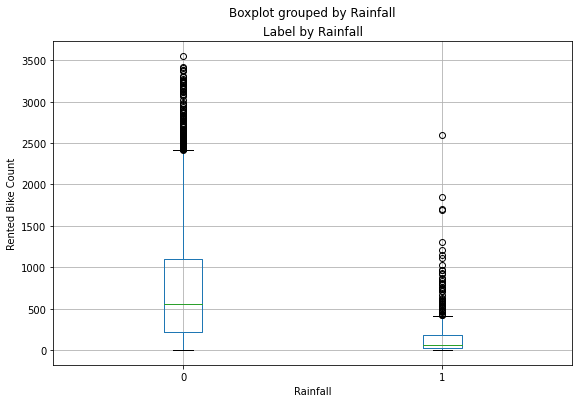

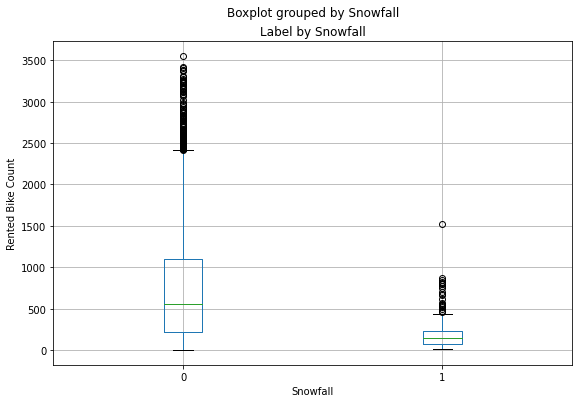

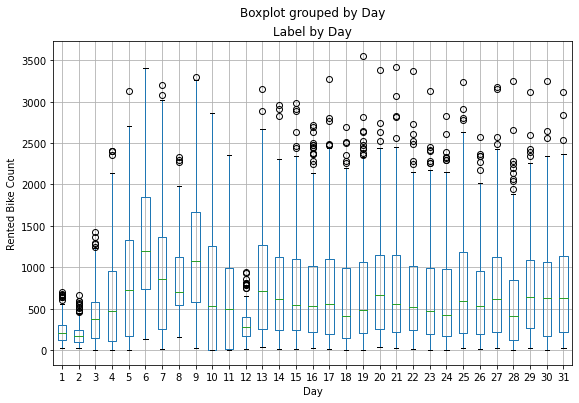

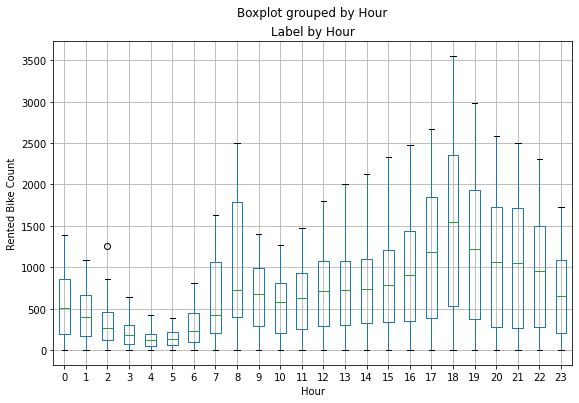

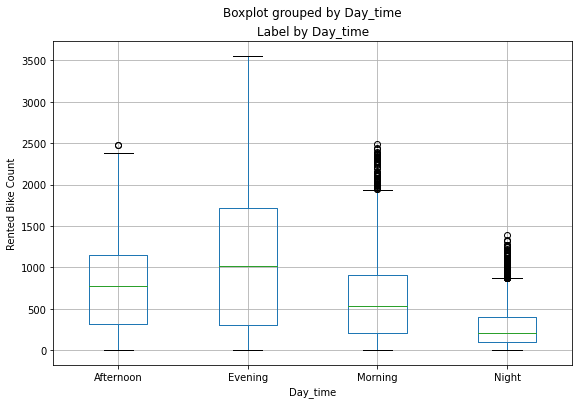

In [17]:
# Plotting a boxplot for each categorical Variable
for col in categorical_features:
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  bike_df.boxplot(column = 'Rented Bike Count', by = col, ax= ax)
  ax.set_title('Label by ' + col)
  ax.set_ylabel('Rented Bike Count')
plt.show()

## Multivariate Analysis

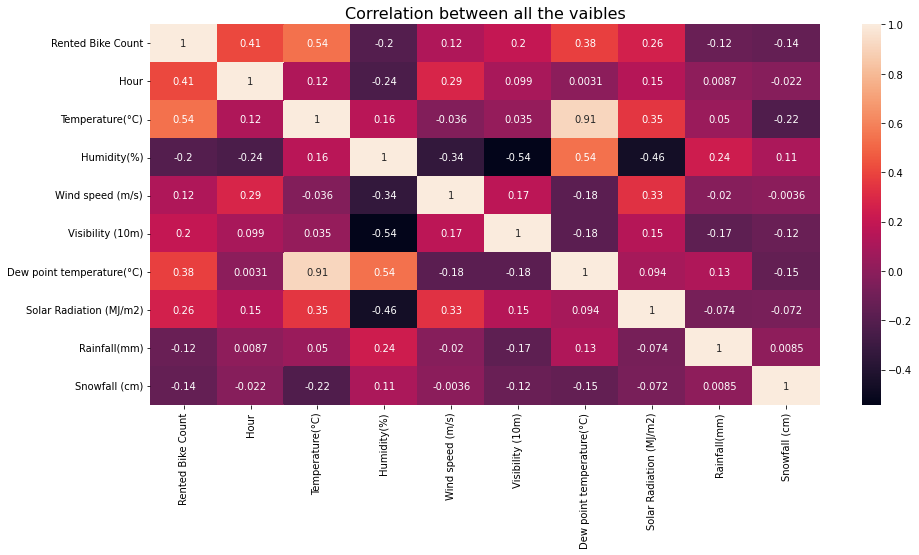

In [18]:
 #visualization of the correlation in the heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True)
plt.title('Correlation between all the vaibles', size=16)
plt.show()

## Checking for Multicollinearity using Variance Inflation Factor

In [19]:
def cal_vif(X):
  vif = pd.DataFrame()
  vif['Variables'] = X.columns
  vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range (X.shape[1])]
  return vif

In [20]:
cal_vif(bike_df[[i for i in bike_df.describe().columns if i not in ['Temperature']]])

,Variables,VIF
0,Rented Bike Count,3.342276
1,Hour,4.738299
2,Humidity,5.006892
3,Wind Speed,3.721516
4,Dew Point Temp,1.763485
5,Day,3.708912


## Data Preprocessing

In [21]:
print('Numeric Features : ', numeric_features)
print('Categorical Features : ', categorical_features)

Numeric Features :  ['Temperature', 'Humidity', 'Wind Speed', 'Dew Point Temp']
Categorical Features :  ['Seasons', 'Holiday', 'Functioning Day', 'Year', 'Month', 'Day_name', 'is_weekend', 'Visibility', 'Solar Radiation', 'Rainfall', 'Snowfall', 'Day', 'Hour', 'Day_time']


In [22]:
X1 = bike_df[['Seasons','Holiday','Functioning Day','Functioning Day','Year','Month','Visibility','Solar Radiation','Rainfall','Snowfall','Hour','Day_time',
             'Humidity','Wind Speed','Dew Point Temp']]
y1 = bike_df['Rented Bike Count']
X= X1.values
y=y1.values
print('Features: ',X[:10], '\nLabels: ',y[:10], sep='\n')

Features: 
[['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 0 'Night'
  37 2.2 -17.6]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 1 'Night'
  38 0.8 -17.6]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 2 'Night'
  39 1.0 -17.7]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 3 'Night'
  40 0.9 -17.6]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 4 'Night'
  36 2.3 -18.6]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 5 'Night'
  37 1.5 -18.7]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 6
  'Morning' 35 1.3 -19.5]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 7
  'Morning' 38 0.9 -19.3]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '1' '0' '0' 8
  'Morning' 37 1.1 -19.8]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '1' '0' '0' 9
  'Morning' 27 0.5 -22.4]]

Labels: 
[254 204 173 107  78 100 181 460 930 490]


### Splitting the Dataset into Training and Test Dataset

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=1)
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape: ', X_test.shape)
print('y_test Shape: ', y_test.shape)

X_train Shape:  (7008, 15)
y_train Shape:  (7008,)
X_test Shape:  (1752, 15)
y_test Shape:  (1752,)


# Data Preprocessing

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

# Define preprocessing for categorical features(encode them)
cat_features = [0,1,2,3,4,5,6,7,8,9,10,11]
categorical_transformer = Pipeline(steps=[
    ('Encoder', OneHotEncoder(handle_unknown='ignore'))])

# define preprocessing for Numerical Features (Feature Scaling)
num_features =[12,13,14]
numeric_transformer = Pipeline(steps=[
    ('Scaler',StandardScaler())])

# Combining Preprocessing Steps
preprocessor= ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])


# Training the Model

In [25]:
# Creating list of models and their respective scores for model comparision
models=[]
MSE=[]
RMSE=[]
R_2 =[]

## 1. Linear Algorithms

### A. Linear Regression (OLS- Ordinary Least Squares)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  [12, 13, 14]),
                                                 ('cat',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11])])),
                ('regressor', LinearRegression())])
_____________________________________________________________________________________________________________________________
linreg_MSE : 125722.81153135213
linreg_RMSE : 354.5741269908905
linreg_R2 Score : 0.6958004438019447
___________

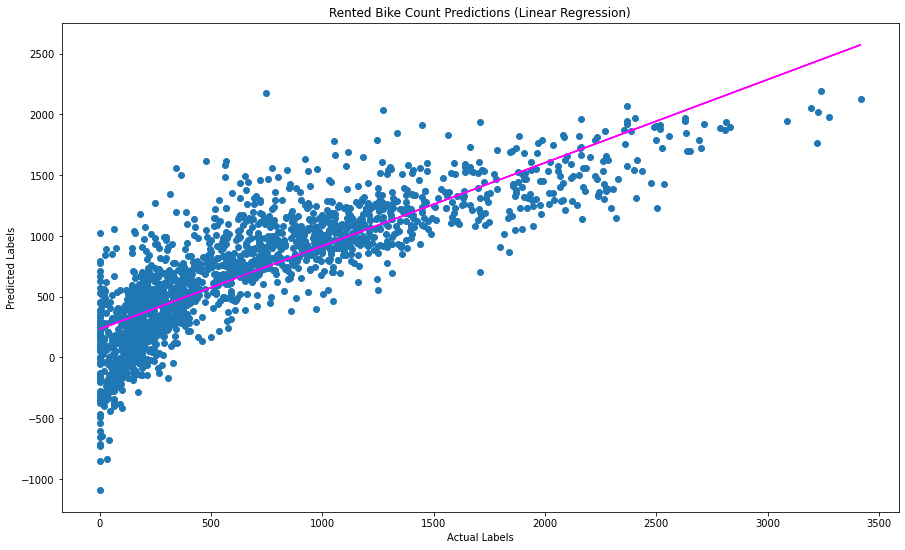

In [26]:
from sklearn.linear_model import LinearRegression

model= 'Linear Regression'
models.append(model)

# Create Preprocessing and Training Pipeline
lin_reg_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor', LinearRegression())])

# Fit the pipeline to train a linear regression model on the training set
linreg_model = lin_reg_pipeline.fit(X_train,(y_train))
print(linreg_model)
print('_'*125)

# Get Predictions
linreg_predictions = linreg_model.predict(X_test)

# Display metrics
from sklearn.metrics import r2_score, mean_squared_error
linreg_mse = mean_squared_error(y_test, linreg_predictions)
print('linreg_MSE :', linreg_mse)
MSE.append(linreg_mse)
linreg_rmse = np.sqrt(linreg_mse)
print('linreg_RMSE :', linreg_rmse)
RMSE.append(linreg_rmse)
linreg_r2 = r2_score(y_test,linreg_predictions)
print('linreg_R2 Score :', linreg_r2)
R_2.append(linreg_r2)
print('_'*125)

# Plot predicted vs actual
plt.figure(figsize=(15,9))
plt.scatter(y_test, linreg_predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Rented Bike Count Predictions (Linear Regression)')
z= np.polyfit(y_test, linreg_predictions,1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

### B. Lasso

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  [12, 13, 14]),
                                                 ('cat',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11])])),
                ('regressor', Lasso())])
_____________________________________________________________________________________________________________________________
lasso_MSE : 126368.22255926969
lasso_RMSE : 355.4830833658188
lasso_R2 Score : 0.6942388039860161
_________________________

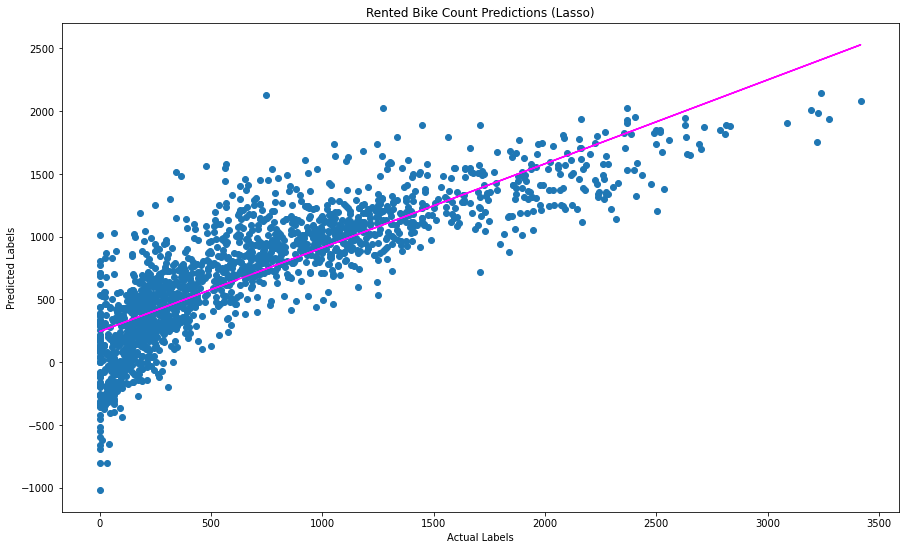

In [27]:
from sklearn.linear_model import Lasso

model = 'Regularized Linear Regression(Lasso)'
models.append(model)

# Create Preprocessing and Training Pipeline
lasso_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor', Lasso())])

# Fit the pipeline to train a linear regression model on the training set
lasso_model = lasso_pipeline.fit(X_train,(y_train))
print(lasso_model)
print('_'*125)

# Get Predictions
lasso_predictions = lasso_model.predict(X_test)

# Display metrics
from sklearn.metrics import r2_score, mean_squared_error
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print('lasso_MSE :', lasso_mse)
MSE.append(lasso_mse)
lasso_rmse = np.sqrt(lasso_mse)
print('lasso_RMSE :', lasso_rmse)
RMSE.append(lasso_rmse)
lasso_r2 = r2_score(y_test,lasso_predictions)
print('lasso_R2 Score :', lasso_r2)
R_2.append(lasso_r2)
print('_'*125)

# Plot predicted vs actual
plt.figure(figsize=(15,9))
plt.scatter(y_test, lasso_predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Rented Bike Count Predictions (Lasso)')
z= np.polyfit(y_test, lasso_predictions,1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

## Lasso(Optimized)

Best parameter combination: {'alpha': 0.1} 

_____________________________________________________________________________________________________________________________
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  [12, 13, 14]),
                                                 ('cat',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11])])),
                ('regressor', Lasso(alpha=0.1))])
_____________________________________________________________________

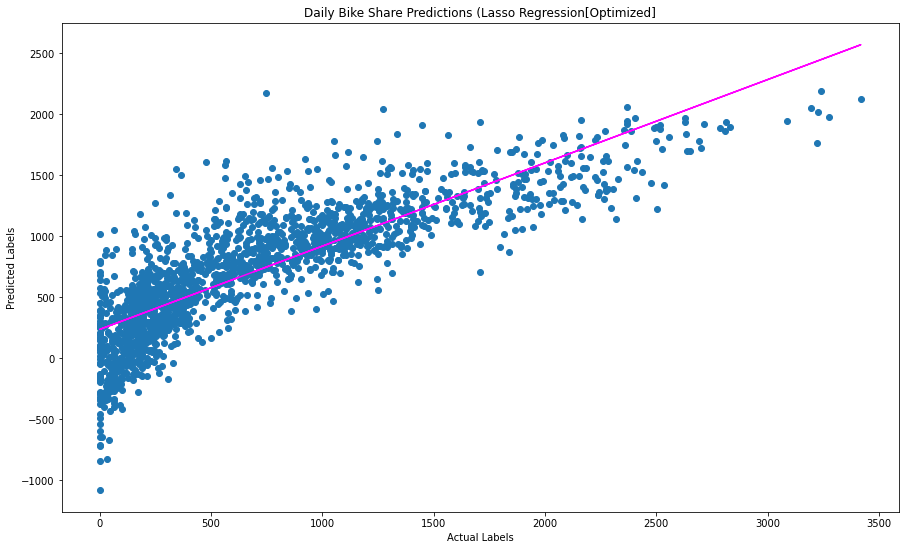

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

model = 'Regularised Linear Regression(Lasso Optimized)'
models.append(model)

# Defining algorithms and Parameter
alg = Lasso()
parameters = {'alpha':[1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
score = make_scorer(r2_score)
lasso_gridsearch = GridSearchCV(alg,parameters,scoring=score,cv=3, return_train_score=True)

# Find the best hyperparameter combination to optimize the R2 metric
lasso_gsc_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                                     ('regressor', lasso_gridsearch)])
lasso_gsc_model = lasso_gsc_pipeline.fit(X_train,(y_train))
print("Best parameter combination:", lasso_gridsearch.best_params_, "\n")

# Get the best model
lasso_gridsearch_model=lasso_gridsearch.best_estimator_
print('_'*125)

# Training the model with best optimizers
lasso_optimized_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                                           ('regressor', lasso_gridsearch_model)])
lasso_optimized_model = lasso_optimized_pipeline.fit(X_train,(y_train))
print(lasso_optimized_model)
print('_'*125)

# Evaluate the model using the test data
lasso_optimized_predictions = lasso_optimized_model.predict(X_test)
lasso_optimized_mse = mean_squared_error(y_test, lasso_optimized_predictions)
print("lasso_optimized_MSE:", lasso_optimized_mse)
MSE.append(lasso_optimized_mse)
lasso_optimized_rmse = np.sqrt(lasso_optimized_mse)
print("lasso_optimized_RMSE:", lasso_optimized_rmse)
RMSE.append(lasso_optimized_rmse)
lasso_optimized_r2 = r2_score(y_test, lasso_optimized_predictions)
print("lasso_optimized_R2:", lasso_optimized_r2)
R_2.append(lasso_optimized_r2)
print('_'*125)

# Plot predicted vs actual
plt.figure(figsize=(15,9))
plt.scatter(y_test, lasso_optimized_predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions (Lasso Regression[Optimized]')
# overlay the regression line
z = np.polyfit(y_test, lasso_optimized_predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## 2. Ensemble Algorithms

### A. Random Forest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  [12, 13, 14]),
                                                 ('cat',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11])])),
                ('regressor', RandomForestRegressor())])
_____________________________________________________________________________________________________________________________
rf_MSE : 60556.13451227169
rf_RMSE : 246.08156069131164
rf_R2 Score : 0.8534780679868187
__________________

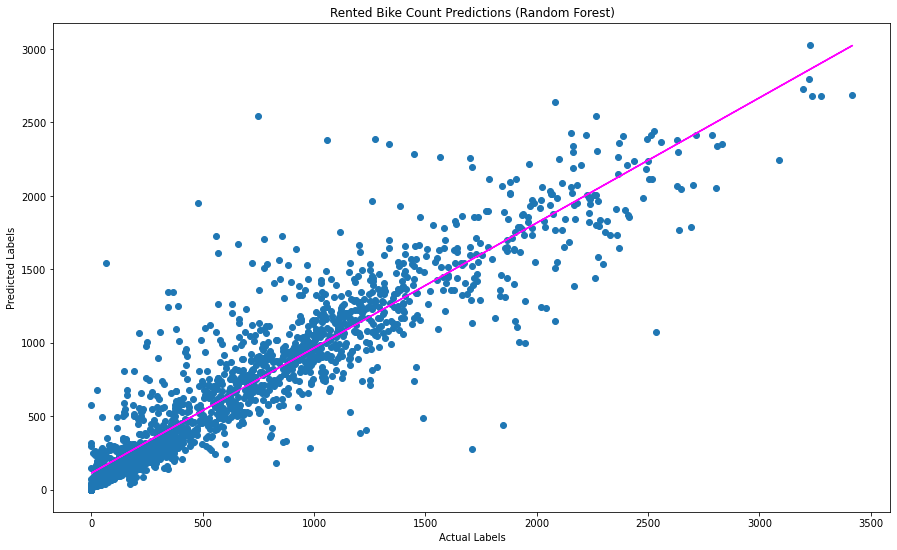

In [29]:
from sklearn.ensemble import RandomForestRegressor
model = 'Random Forest'
rf =RandomForestRegressor()
models.append(model)
# Create Preprocessing and Training Pipeline
rf_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor', rf)])

# Fit the pipeline to train a linear regression model on the training set
rf_model = rf_pipeline.fit(X_train,(y_train))
print(rf_model)
print('_'*125)

# Get Predictions
rf_predictions = rf_model.predict(X_test)

# Display metrics
from sklearn.metrics import r2_score, mean_squared_error
rf_mse = mean_squared_error(y_test, rf_predictions)
print('rf_MSE :', rf_mse)
MSE.append(rf_mse)
rf_rmse = np.sqrt(rf_mse)
print('rf_RMSE :', rf_rmse)
RMSE.append(rf_rmse)
rf_r2 = r2_score(y_test,rf_predictions)
print('rf_R2 Score :', rf_r2)
R_2.append(rf_r2)
print('_'*125)

# Plot predicted vs actual
plt.figure(figsize=(15,9))
plt.scatter(y_test, rf_predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Rented Bike Count Predictions (Random Forest)')
z= np.polyfit(y_test, rf_predictions,1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

## Random Forest (Optimized)

Best parameter combination: {'max_depth': 7, 'max_features': 10, 'n_estimators': 300, 'random_state': 1} 

_____________________________________________________________________________________________________________________________
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  [12, 13, 14]),
                                                 ('cat',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11])])),
                ('regressor',
                 RandomFore

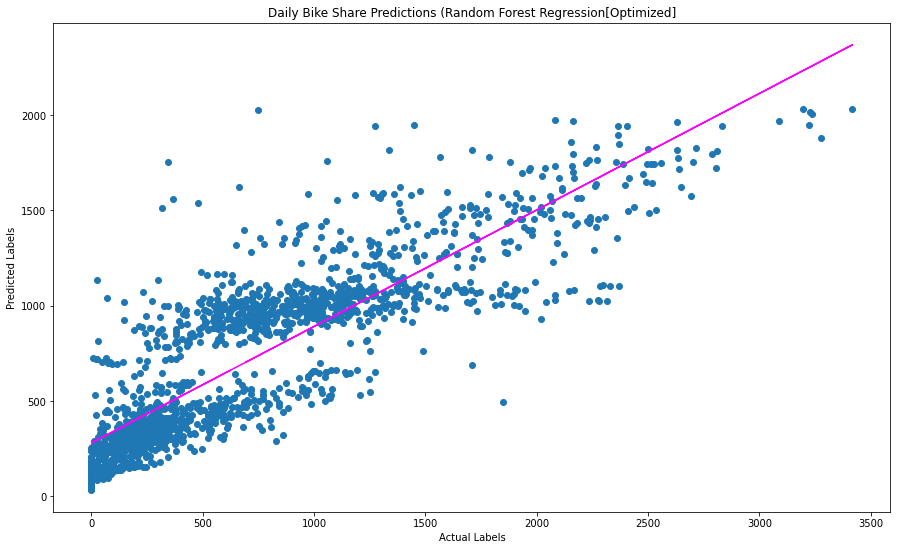

In [30]:
model = 'Random Forest(Optimized)'
models.append(model)

alg = RandomForestRegressor()
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_features':[1,5,10],
    'max_depth': [4,5,6,7],
    'random_state':[1]}
score = make_scorer(r2_score)
rf_gridsearch = GridSearchCV(alg,parameters,scoring=score,cv=3, return_train_score=True)

# Find the best hyperparameter combination to optimize the R2 metric
rf_gsc_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                                     ('regressor', rf_gridsearch)])
rf_gsc_model = rf_gsc_pipeline.fit(X_train,(y_train))
print("Best parameter combination:", rf_gridsearch.best_params_, "\n")

# Get the best model
rf_gridsearch_model=rf_gridsearch.best_estimator_
print('_'*125)

# Training the model with best optimizers
rf_optimized_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                                           ('regressor', rf_gridsearch_model)])
rf_optimized_model = rf_optimized_pipeline.fit(X_train,(y_train))
print(rf_optimized_model)
print('_'*125)

# Evaluate the model using the test data
rf_optimized_predictions = rf_optimized_model.predict(X_test)
rf_optimized_mse = mean_squared_error(y_test, rf_optimized_predictions)
print("rf_optimized_MSE:", rf_optimized_mse)
MSE.append(rf_optimized_mse)
rf_optimized_rmse = np.sqrt(rf_optimized_mse)
print("rf_optimized_RMSE:", rf_optimized_rmse)
RMSE.append(rf_optimized_rmse)
rf_optimized_r2 = r2_score(y_test, rf_optimized_predictions)
print("rf_optimized_R2:", rf_optimized_r2)
R_2.append(rf_optimized_r2)
print('_'*125)

# Plot predicted vs actual
plt.figure(figsize=(15,9))
plt.scatter(y_test, rf_optimized_predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions (Random Forest Regression[Optimized]')
# overlay the regression line
z = np.polyfit(y_test, rf_optimized_predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

### B. Gradient Boosting

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  [12, 13, 14]),
                                                 ('cat',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11])])),
                ('regressor', GradientBoostingRegressor())])
_____________________________________________________________________________________________________________________________
gb_MSE : 81551.56393821904
gb_RMSE : 285.5723444912323
gb_R2 Score : 0.8026774198326206
_______________

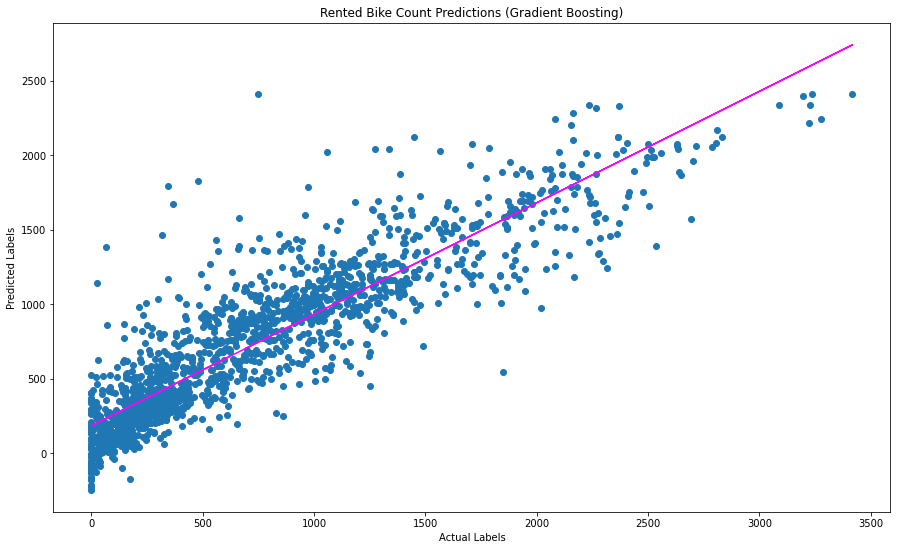

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

model='Gradiend Boosting'
models.append(model)
# Create Preprocessing and Training Pipeline
gb_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor', GradientBoostingRegressor())])

# Fit the pipeline to train a linear regression model on the training set
gb_model = gb_pipeline.fit(X_train,(y_train))
print(gb_model)
print('_'*125)

# Get Predictions
gb_predictions = gb_model.predict(X_test)

# Display metrics
from sklearn.metrics import r2_score, mean_squared_error
gb_mse = mean_squared_error(y_test, gb_predictions)
print('gb_MSE :', gb_mse)
MSE.append(gb_mse)
gb_rmse = np.sqrt(gb_mse)
print('gb_RMSE :', gb_rmse)
RMSE.append(gb_rmse)
gb_r2 = r2_score(y_test,gb_predictions)
print('gb_R2 Score :', gb_r2)
R_2.append(gb_r2)
print('_'*125)

# Plot predicted vs actual
plt.figure(figsize=(15,9))
plt.scatter(y_test, gb_predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Rented Bike Count Predictions (Gradient Boosting)')
z= np.polyfit(y_test, gb_predictions,1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

## Gradient Boosting Optimized

Best parameter combination: {'learning_rate': 0.3, 'n_estimators': 150} 

_____________________________________________________________________________________________________________________________
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  [12, 13, 14]),
                                                 ('cat',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.3

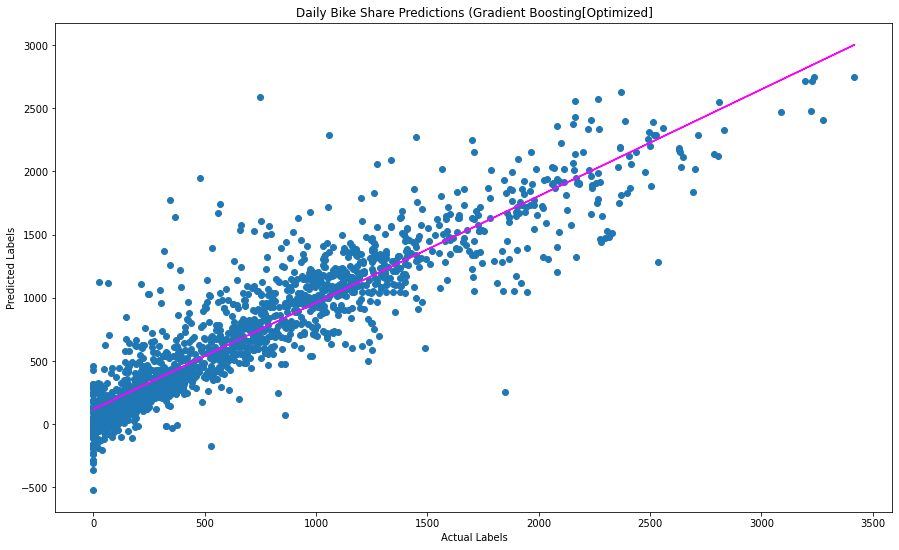

In [32]:
model = 'Gradiend Boosting(Optimized)'
models.append(model)

alg = GradientBoostingRegressor()
parameters = {'learning_rate': [0.1,0.3, 0.5, 0.7,1.0],
              'n_estimators' : [50, 75, 100, 125, 150]}
score = make_scorer(r2_score)
GBM_gridsearch = GridSearchCV(alg,parameters,scoring=score,cv=3, return_train_score=True)

# Find the best hyperparameter combination to optimize the R2 metric
GBM_gsc_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                                     ('regressor', GBM_gridsearch)])
GBM_gsc_model = GBM_gsc_pipeline.fit(X_train,(y_train))
print("Best parameter combination:", GBM_gridsearch.best_params_, "\n")

# Get the best model
GBM_gridsearch_model=GBM_gridsearch.best_estimator_
print('_'*125)

# Training the model with best optimizers
GBM_optimized_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                                           ('regressor', GBM_gridsearch_model)])
GBM_optimized_model = GBM_optimized_pipeline.fit(X_train,(y_train))
print(GBM_optimized_model)
print('_'*125)

# Evaluate the model using the test data
GBM_optimized_predictions = GBM_optimized_model.predict(X_test)
GBM_optimized_mse = mean_squared_error(y_test, GBM_optimized_predictions)
print("GBM_optimized_MSE:", GBM_optimized_mse)
MSE.append(GBM_optimized_mse)
GBM_optimized_rmse = np.sqrt(GBM_optimized_mse)
print("GBM_optimized_RMSE:", GBM_optimized_rmse)
RMSE.append(GBM_optimized_rmse)
GBM_optimized_r2 = r2_score(y_test, GBM_optimized_predictions)
print("GBM_optimized_R2:", GBM_optimized_r2)
R_2.append(GBM_optimized_r2)
print('_'*125)

# Plot predicted vs actual
plt.figure(figsize=(15,9))
plt.scatter(y_test, GBM_optimized_predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions (Gradient Boosting[Optimized]')
# overlay the regression line
z = np.polyfit(y_test, GBM_optimized_predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

### A. Decision Tree

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  [12, 13, 14]),
                                                 ('cat',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11])])),
                ('regressor', DecisionTreeRegressor())])
_____________________________________________________________________________________________________________________________
dtree_MSE : 114738.69349315068
dtree_RMSE : 338.7310046233599
dtree_R2 Score : 0.7223776718463135
_________

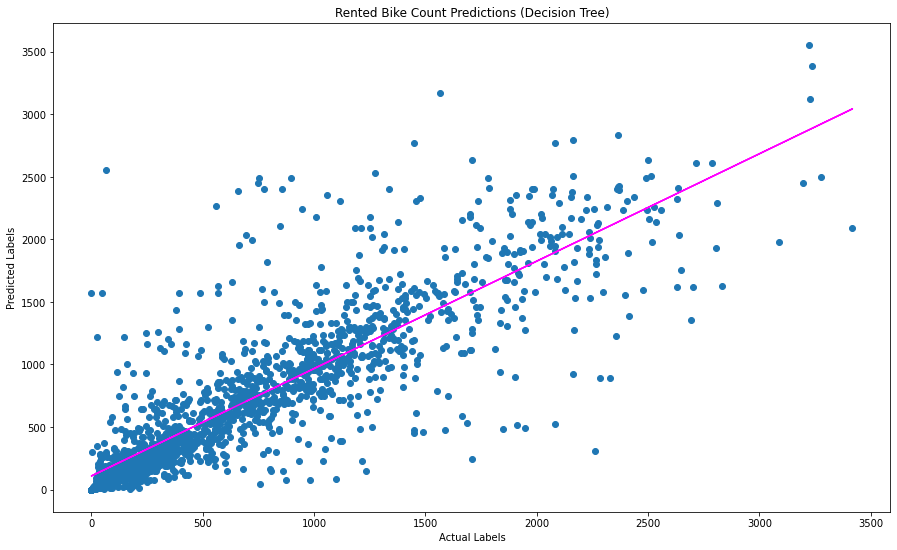

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

model = 'Decision Tree'
models.append(model)
# Create Preprocessing and Training Pipeline
dtree_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor', DecisionTreeRegressor())])

# Fit the pipeline to train a linear regression model on the training set
dtree_model = dtree_pipeline.fit(X_train,(y_train))
print(dtree_model)
print('_'*125)

# Get Predictions
dtree_predictions = dtree_model.predict(X_test)

# Display metrics
from sklearn.metrics import r2_score, mean_squared_error
dtree_mse = mean_squared_error(y_test, dtree_predictions)
print('dtree_MSE :', dtree_mse)
MSE.append(dtree_mse)
dtree_rmse = np.sqrt(dtree_mse)
print('dtree_RMSE :', dtree_rmse)
RMSE.append(dtree_rmse)
dtree_r2 = r2_score(y_test,dtree_predictions)
print('dtree_R2 Score :', dtree_r2)
R_2.append(dtree_r2)
print('_'*125)

# Plot predicted vs actual
plt.figure(figsize=(15,9))
plt.scatter(y_test, dtree_predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Rented Bike Count Predictions (Decision Tree)')
z= np.polyfit(y_test, dtree_predictions,1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

In [34]:
models_df = pd.DataFrame(
    {'Models': models,
     'MSE': MSE,
     'RMSE': RMSE,
     'R_2' : R_2})
models_df.sort_values(by=['R_2'],ascending=False,inplace=True)
models_df

,Models,MSE,RMSE,R_2
3,Random Forest,60556.134512,246.081561,0.853478
6,Gradiend Boosting(Optimized),65979.720466,256.865180,0.840355
5,Gradiend Boosting,81551.563938,285.572344,0.802677
7,Decision Tree,114738.693493,338.731005,0.722378
4,Random Forest(Optimized),115173.209923,339.371787,0.721326
2,Regularised Linear Regression(Lasso Optimized),125709.776395,354.555745,0.695832
0,Linear Regression,125722.811531,354.574127,0.695800
1,Regularized Linear Regression(Lasso),126368.222559,355.483083,0.694239


Random Forest looks the best model to deploy
